In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
# from torchvision.models import resnet50, swin_v2_b
from transformers import AutoFeatureExtractor, AutoImageProcessor, ViTForImageClassification

# Transfer Learning with a Pre-Trained Vision Transformer

In [3]:
torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Ingestion

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
root_path = "/content/drive/Othercomputers/My MacBook Pro 2021/Documents/ai-image-detection/root"
# root_path = "/content/drive/Othercomputers/My MacBook Pro 2021/Documents/Cornell/CS 5787/CS 5787 - Final Project/data/root"

In [6]:
def load_dalle(feature_extractor, BATCH_SIZE):

    # AutoFeatureExtractor
    def transform(image):
        return feature_extractor(image, return_tensors='pt')['pixel_values'].squeeze()
    
    ds = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

    # 80/20 train-test split
    ds_train, ds_test = torch.utils.data.random_split(ds, lengths=[round(0.8 * len(ds)), round(0.2 * len(ds))])

    # DataLoaders: loads and shuffles the training dataset in mini-batches
    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)
    
    return ds, train_loader, test_loader

In [7]:
# Load dataset
ds, train_loader, test_loader = load_dalle(AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224"), 64)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [8]:
class_counts = pd.Series(ds.targets).value_counts().to_frame('n_samples')
class_counts['class'] = class_counts.index.map({k:v for v, k in ds.class_to_idx.items()})
class_counts

,n_samples,class
0,1000,class_control
1,1000,class_dalle
2,1000,class_midjourney
3,1000,class_stable_diffusion


## Model Initialization

Create a hook to save the output of the last hidden layer (in this case linear layer)

In [9]:
from transformers import SwinModel

In [10]:
modelSwin = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
modelSwin = modelSwin.to(DEVICE)
# image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Feature Extraction

In [11]:
def extract_features(loader, model):

    # Create a hook to save the output of the last hidden layer (in this case linear layer)
    linear_layer = [layer for layer in model.modules() if isinstance(layer, torch.nn.Linear)]

    saved_outputs = []
    def create_hook(module: torch.nn.Module, input: torch.Tensor, output: torch.Tensor):
        saved_outputs.extend(output)

    linear_layer[-1].register_forward_hook(create_hook)

    # Run the images through the model
    labels = []
    for inputs, targets in tqdm(loader):
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
            output = model(inputs)
            # for image in tqdm(X_train):
            #     output = modelSwin(torch.from_numpy(image).unsqueeze(0))
        labels.extend(targets.cpu().numpy())
    
    # Combine list of sample features into one tensor
    features = torch.stack(saved_outputs, dim=0)

    # Normalize the features by dividing by the L2 norm
    norms = torch.linalg.norm(features, dim=1)
    eps = 1e-6 #to avoid division by zero
    features = features / (norms[:, None] + eps)

    # reshape the features to be 1D
    features = torch.flatten(features, start_dim=1)

    return features.cpu().numpy(), np.array(labels)

In [12]:
%%time
# Extract features and labels
X_train, y_train = extract_features(train_loader, modelSwin)
X_test, y_test = extract_features(test_loader, modelSwin)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 23.9 s, sys: 2.48 s, total: 26.4 s
Wall time: 22min 19s


## Classification

### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [14]:
# Create the model
clf = LogisticRegressionCV(n_jobs=-1, max_iter=100000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegressionCV(max_iter=100000, n_jobs=-1, random_state=42)

## Evaluation

In [15]:
class_counts

,n_samples,class
0,1000,class_control
1,1000,class_dalle
2,1000,class_midjourney
3,1000,class_stable_diffusion


### Train

In [16]:
# Classify training features and calculate mean-per-class accuracy
y_pred = clf.predict(X_train)
print(X_train.shape)
print(classification_report(y_train, y_pred))
print("Mean-per-class accuracy:", accuracy_score(y_train, y_pred))

(3200, 37632)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       780
           1       1.00      1.00      1.00       812
           2       1.00      1.00      1.00       808
           3       1.00      1.00      1.00       800

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200

Mean-per-class accuracy: 1.0


### Test

In [17]:
# Classify test features and calculate mean-per-class accuracy
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Mean-per-class accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       220
           1       0.81      0.81      0.81       188
           2       0.82      0.88      0.84       192
           3       0.88      0.86      0.87       200

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800

Mean-per-class accuracy: 0.8625


Text(0.5, 1.0, 'Confusion Matrix: Swin Transformer')

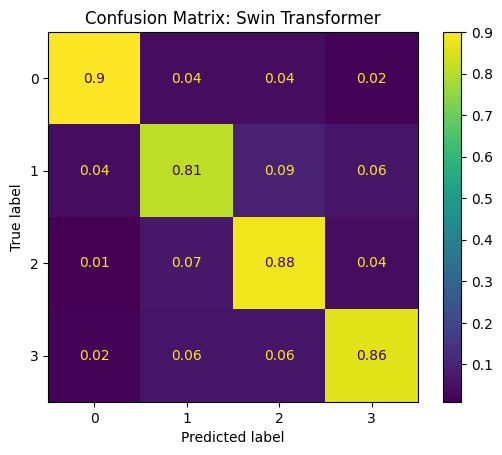

In [18]:
cm = np.round((confusion_matrix(y_test, y_pred, normalize = "true")),2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix: Swin Transformer')

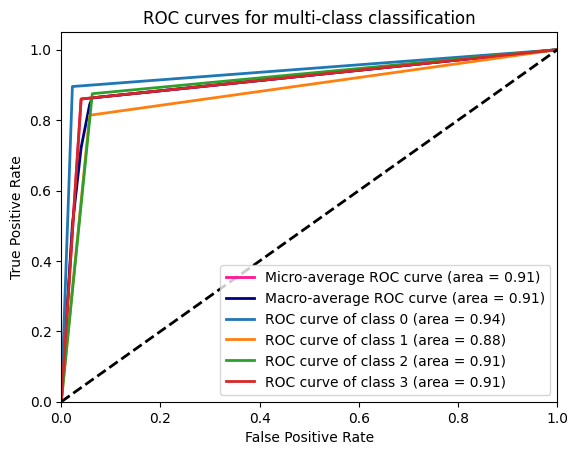

In [19]:
# Compute binary ROC curves and ROC areas for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    y_test_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_bin)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 4
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr_micro, tpr_micro, color='deeppink',
         lw=lw, label='Micro-average ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot(fpr_macro, tpr_macro, color='navy',
         lw=lw, label='Macro-average ROC curve (area = %0.2f)' % roc_auc_macro)
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multi-class classification')
plt.legend(loc="lower right")
plt.show()
